<strong> Import all libraires that will be used </strong>

In [13]:
from utils import PaintingsDataset, Generator, Discriminator
import random
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

<strong> Initializing the paintings dataset </strong>

In [14]:
# Building the dataset
image_dir = '../../data/resized/resized/'

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((128,128)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
paintings = PaintingsDataset(image_dir, transform)

<strong> Sampling an element from the dataset and plotting it </strong>

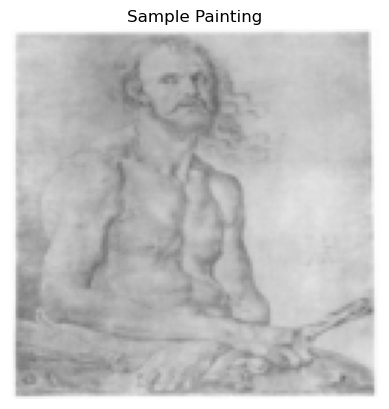

In [15]:
# Sampling randomly an element from the dataset
n = len(paintings)
integer = random.randint(0,n)

# Sampled image
image = paintings[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()


<strong> Intializing the Dataloader </strong>

In [16]:
dataloader = DataLoader(paintings, batch_size=16)

<strong> Initializing the parameters of the model </strong>

In [17]:
# Model's parameters
latent_dim = 40
channels_out = 3
channels_in = 3

# Intializing the models
G = Generator(latent_dim, channels_out)
D = Discriminator(channels_in)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

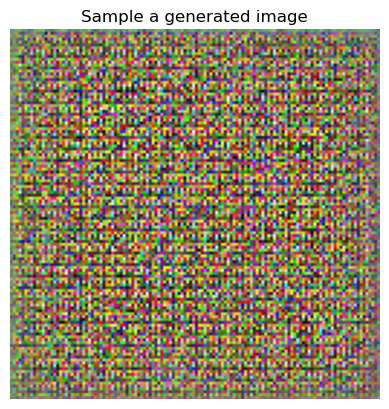

In [18]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# De-normalizing the image
image_generated = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a generated image')
plt.show()


<strong> Training loop </strong>

In [19]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define models and parameters 
generator = G.to(device)  # Move generator to GPU
discriminator = D.to(device)  # Move discriminator to GPU
epochs = 300
epoch_eval = epochs // 10
k = 3 # Steps to train generator
epoch_print = 1 # Print performance
latent_dim = 40

# Loss function and optimizers
criterion = torch.nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.99, 0.99))
optimizer_d = optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.99, 0.99))


fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(paintings)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []
D_loss = []
G_loss =  []


for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):

        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1, device=device)  # Real labels on GPU

        # Train discriminator with real images
        discriminator.zero_grad()
        output = discriminator(real_images)
        loss_d_real = criterion(output, labels_real)

        # Train discriminator with fake images
        labels_fake = torch.zeros(batch_size, 1, device=device)  # Real labels on GPU
        noise = torch.rand(batch_size, latent_dim, 1, 1, device=device) * 2 - 1

         # Generate noise on GPU
        fake_images = generator(noise)

        output = discriminator(fake_images.detach())
        loss_d_fake = criterion(output, labels_fake)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d.step()

        if epoch % k == 0:
            # Train generator
            labels_real_g = torch.ones(batch_size, 1, device=device)  # Real labels on GPU

            generator.zero_grad()

            output = discriminator(fake_images)
            loss_g = criterion(output, labels_real_g)
            loss_g.backward()

            optimizer_g.step()
    
    if epoch % epoch_eval == 0:
        # Eval mode
        G_eval = generator.eval()

        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_eval(noise).to(torch.device('cpu'))

        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())

        # Train mode
        generator.train()
    
    end_time = time.time()
    if epoch % epoch_print == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

<strong> Generating an element using the trained generator </strong>

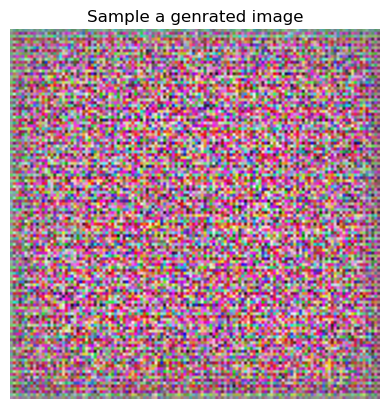

In [ ]:
G_eval = G.to(device=torch.device('cpu'))
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# Denormalizing the image
image_generated = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a genrated image')
plt.show()

<strong> Plotting losses </strong>

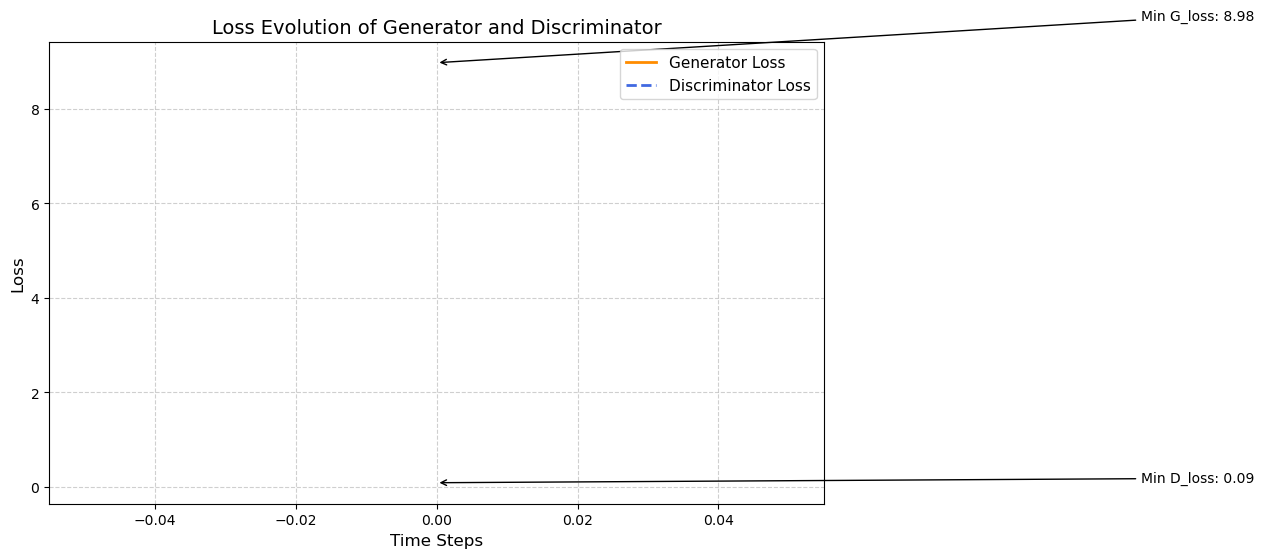

In [ ]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

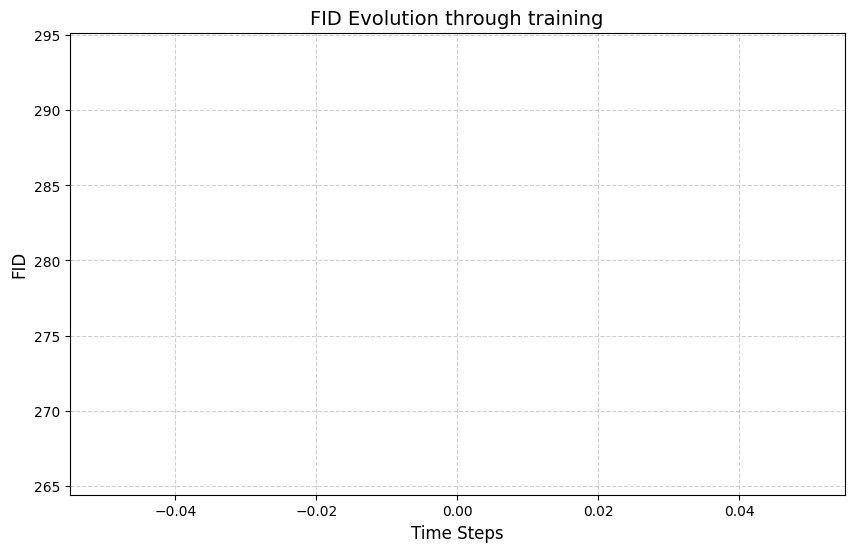

In [14]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)